In [4]:
import os
import numpy as np
import scipy.io
import torch
from torch.utils.data import Dataset
from PIL import Image
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import cv2

def get_monitor_params(calib_dir):
    monitor = scipy.io.loadmat(os.path.join(calib_dir, 'monitorPose.mat'))
    screen = scipy.io.loadmat(os.path.join(calib_dir, 'screenSize.mat'))

    R_monitor, _ = cv2.Rodrigues(monitor['rvects'])
    T_monitor = monitor['tvecs'].reshape(3)

    screen_mm = {
        'w': screen['width_mm'][0][0],
        'h': screen['height_mm'][0][0],
        'w_px': screen['width_pixel'][0][0],
        'h_px': screen['height_pixel'][0][0]
    }

    return R_monitor, T_monitor, screen_mm

def intersect_ray_plane(eye, ray, plane_point, plane_normal):
    denom = np.dot(ray, plane_normal)
    if np.abs(denom) < 1e-6:
        return None
    t = np.dot(plane_point - eye, plane_normal) / denom
    return eye + t * ray

def gaze_to_screen_xy(eye_pos, gaze_dir, R, T, screen_mm):
    plane_normal = R[:, 2]
    plane_point = T
    hit = intersect_ray_plane(eye_pos, gaze_dir, plane_point, plane_normal)
    if hit is None:
        return None

    screen_coords_mm = R.T @ (hit - T)

    x_mm = screen_coords_mm[0]
    y_mm = screen_coords_mm[1]

    x_norm = x_mm / screen_mm['w']
    y_norm = y_mm / screen_mm['h']
    return torch.tensor([x_norm, y_norm], dtype=torch.float32)

class MPIIGazeDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.samples = []
        self.transform = transform

        for subject in sorted(os.listdir(root_dir)):
            subj_path = os.path.join(root_dir, subject)
            if not os.path.isdir(subj_path) or not subject.startswith("p"):
                continue

            calib_dir = os.path.join(subj_path, 'Calibration')
            R, T, screen_mm = get_monitor_params(calib_dir)

            for day in sorted(os.listdir(subj_path)):
                day_path = os.path.join(subj_path, day)
                if not os.path.isdir(day_path) or not day.startswith("day"):
                    continue

                anno_file = os.path.join(day_path, 'annotation.txt')
                if not os.path.exists(anno_file):
                    continue

                with open(anno_file, 'r') as f:
                    lines = f.readlines()

                for idx, line in enumerate(lines):
                    values = list(map(float, line.strip().split()))
                    if len(values) < 41:
                        continue

                    image_path = os.path.join(day_path, f"{idx + 1:04d}.jpg")
                    if not os.path.exists(image_path):
                        raise Exception

                    eye = np.array(values[35:38])
                    gaze = np.array(values[26:29])
                    gaze = gaze / np.linalg.norm(gaze)

                    screen_xy = gaze_to_screen_xy(eye, gaze, R, T, screen_mm)
                    if screen_xy is None:
                        raise Exception

                    self.samples.append((image_path, screen_xy))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        image_path, screen_xy = self.samples[idx]
        image = Image.open(image_path).convert("RGB")

        if self.transform:
            image = self.transform(image)

        return image, screen_xy




In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class GazeCNN(nn.Module):
    def __init__(self):
        super(GazeCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=5, stride=1, padding=2)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=5, stride=1, padding=2)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(64 * 28 * 28, 256)
        self.fc2 = nn.Linear(256, 2)

    def forward(self, x):
        x = self.pool1(F.relu(self.conv1(x)))
        x = self.pool2(F.relu(self.conv2(x)))
        x = self.pool3(F.relu(self.conv3(x)))
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x


In [63]:
import torch
from torch.utils.data import DataLoader, random_split
import torchvision.transforms as transforms
import torch.optim as optim

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

subset_size = 1000
print("Creating dataset")
full_dataset = MPIIGazeDataset(root_dir='./MPIIGaze/Data/Original', transform=transform)
subset_dataset = torch.utils.data.Subset(full_dataset, range(subset_size))
print("Dataset created")


train_size = int(0.8 * subset_size)
test_size = subset_size - train_size
train_dataset, test_dataset = random_split(subset_dataset, [train_size, test_size])


train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

model = GazeCNN()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
print("Begining train")
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device).float()

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}")

model.eval()
total_loss = 0.0
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device).float()
        outputs = model(images)
        loss = criterion(outputs, labels)
        total_loss += loss.item()

print(f"Test MSE: {total_loss/len(test_loader):.4f}")


Creating dataset
Dataset created
Begining train
Epoch [1/10], Loss: 65.4060
Epoch [2/10], Loss: 54.8391
Epoch [3/10], Loss: 50.3087
Epoch [4/10], Loss: 48.5920
Epoch [5/10], Loss: 47.7828
Epoch [6/10], Loss: 45.8607
Epoch [7/10], Loss: 44.2446
Epoch [8/10], Loss: 44.0041
Epoch [9/10], Loss: 42.2529
Epoch [10/10], Loss: 40.7429
Test MSE: 48.3817


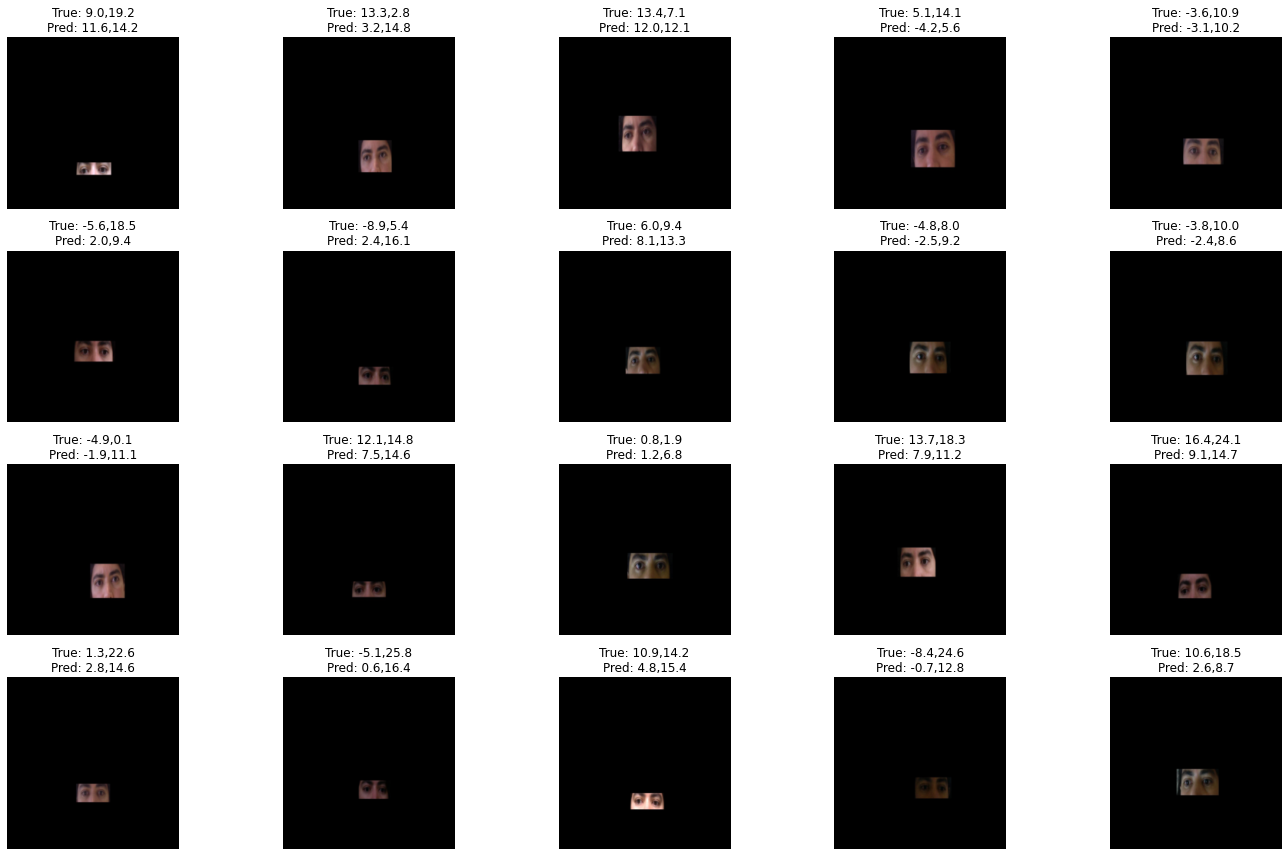

In [65]:
import random
from matplotlib import pyplot as plt

model.eval()
indices = random.sample(range(len(test_dataset)), 20)

fig, axs = plt.subplots(4, 5, figsize=(20, 12))
axs = axs.flatten()

for i, idx in enumerate(indices):
    image, true_xy = test_dataset[idx]
    input_tensor = image.unsqueeze(0).to(device)

    with torch.no_grad():
        pred_xy = model(input_tensor).cpu().squeeze().numpy()

    axs[i].imshow(image.permute(1, 2, 0))
    axs[i].set_title(f"True: {true_xy[0]:.1f},{true_xy[1]:.1f}\nPred: {pred_xy[0]:.1f},{pred_xy[1]:.1f}")
    axs[i].axis('off')

plt.tight_layout()
plt.show()
